In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/Recruit/'

In [3]:
data = {
    'tra': pd.read_csv(f'{PATH}air_visit_data.csv'),
    'as': pd.read_csv(f'{PATH}air_store_info.csv'),
    'hs': pd.read_csv(f'{PATH}hpg_store_info.csv'),
    'ar': pd.read_csv(f'{PATH}air_reserve.csv'),
    'hr': pd.read_csv(f'{PATH}hpg_reserve.csv'),
    'id': pd.read_csv(f'{PATH}store_id_relation.csv'),
    'tes': pd.read_csv(f'{PATH}sample_submission.csv'),
    'hol': pd.read_csv(f'{PATH}date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

In [4]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

In [5]:
for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_dow'] = data[df]['visit_datetime'].dt.dayofweek
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    # Exclude same-week reservations - from aharless kernel
    data[df] = data[df][data[df]['reserve_datetime_diff'] > data[df]['visit_dow']]
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='inner', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

In [6]:
len(test['id'])

32019

In [7]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5



In [9]:
value_col = ['holiday_flg','min_visitors','mean_visitors','median_visitors','max_visitors','count_observations',
'rs1_x','rv1_x','rs2_x','rv2_x','rs1_y','rv1_y','rs2_y','rv2_y','total_reserv_sum','total_reserv_mean',
'total_reserv_dt_diff_mean','date_int','var_max_lat','var_max_long','lon_plus_lat']

nn_col = value_col + ['dow', 'year', 'month', 'air_store_id2', 'air_area_name', 'air_genre_name',
'air_area_name0', 'air_area_name1', 'air_area_name2', 'air_area_name3', 'air_area_name4',
'air_area_name5', 'air_area_name6', 'air_genre_name0', 'air_genre_name1',
'air_genre_name2', 'air_genre_name3', 'air_genre_name4']


X = train.copy()
X_test = test[nn_col].copy()

value_scaler = preprocessing.MinMaxScaler()
for vcol in value_col:
    X[vcol] = value_scaler.fit_transform(X[vcol].values.astype(np.float64).reshape(-1, 1))
    X_test[vcol] = value_scaler.transform(X_test[vcol].values.astype(np.float64).reshape(-1, 1))



In [10]:
X_train = X[nn_col].copy()
Y_train = np.log(X['visitors'])
nn_test = X_test[nn_col]
print("Train and test data prepared")

Train and test data prepared


In [11]:
X_test.columns

Index(['holiday_flg', 'min_visitors', 'mean_visitors', 'median_visitors',
       'max_visitors', 'count_observations', 'rs1_x', 'rv1_x', 'rs2_x',
       'rv2_x', 'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y', 'total_reserv_sum',
       'total_reserv_mean', 'total_reserv_dt_diff_mean', 'date_int',
       'var_max_lat', 'var_max_long', 'lon_plus_lat', 'dow', 'year', 'month',
       'air_store_id2', 'air_area_name', 'air_genre_name', 'air_area_name0',
       'air_area_name1', 'air_area_name2', 'air_area_name3', 'air_area_name4',
       'air_area_name5', 'air_area_name6', 'air_genre_name0',
       'air_genre_name1', 'air_genre_name2', 'air_genre_name3',
       'air_genre_name4'],
      dtype='object')

In [12]:
train.columns

Index(['air_store_id', 'visit_date', 'visitors', 'dow', 'year', 'month',
       'day_of_week', 'holiday_flg', 'min_visitors', 'mean_visitors',
       'median_visitors', 'max_visitors', 'count_observations',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'air_genre_name0', 'air_area_name0', 'air_genre_name1',
       'air_area_name1', 'air_genre_name2', 'air_area_name2',
       'air_genre_name3', 'air_area_name3', 'air_genre_name4',
       'air_area_name4', 'air_genre_name5', 'air_area_name5',
       'air_genre_name6', 'air_area_name6', 'air_genre_name7',
       'air_area_name7', 'air_genre_name8', 'air_area_name8',
       'air_genre_name9', 'air_area_name9', 'rs1_x', 'rv1_x', 'rs2_x', 'rv2_x',
       'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y', 'id', 'total_reserv_sum',
       'total_reserv_mean', 'total_reserv_dt_diff_mean', 'date_int',
       'var_max_lat', 'var_max_long', 'lon_plus_lat', 'air_store_id2'],
      dtype='object')

In [24]:
val_idx=[0]

In [25]:
categoryFields=[t for t in nn_col if t not in value_col]

In [26]:
for v in categoryFields: X_train[v] = X_train[v].astype('category').cat.as_ordered()
for u in categoryFields: X_test[u] = X_test[u].astype('category').cat.as_ordered()


In [27]:
apply_cats(X_test, X_train)

In [28]:
for v in value_col:
    X_train[v] = X_train[v].astype('float32')
    X_test[v] = X_test[v].astype('float32')

In [29]:
X_train['visitors']=X['visitors']

In [30]:
df, y, nas, mapper = proc_df(X_train, 'visitors', do_scale=True)
yl = np.log(y)

In [31]:
X_test['visitors']=0

In [32]:
df_test, _, nas, mapper = proc_df(X_test, 'visitors', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [33]:
df.dtypes

holiday_flg                  float64
min_visitors                 float64
mean_visitors                float64
median_visitors              float64
max_visitors                 float64
count_observations           float64
rs1_x                        float64
rv1_x                        float64
rs2_x                        float64
rv2_x                        float64
rs1_y                        float64
rv1_y                        float64
rs2_y                        float64
rv2_y                        float64
total_reserv_sum             float64
total_reserv_mean            float64
total_reserv_dt_diff_mean    float64
date_int                     float64
var_max_lat                  float64
var_max_long                 float64
lon_plus_lat                 float64
dow                             int8
year                            int8
month                           int8
air_store_id2                  int16
air_area_name                   int8
air_genre_name                  int8
a

In [34]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=categoryFields,bs=256,
                                       test_df=df_test)

In [35]:
categoryFields

['dow',
 'year',
 'month',
 'air_store_id2',
 'air_area_name',
 'air_genre_name',
 'air_area_name0',
 'air_area_name1',
 'air_area_name2',
 'air_area_name3',
 'air_area_name4',
 'air_area_name5',
 'air_area_name6',
 'air_genre_name0',
 'air_genre_name1',
 'air_genre_name2',
 'air_genre_name3',
 'air_genre_name4']

In [36]:
cat_sz = [(c, len(X_train[c].cat.categories)+1) for c in categoryFields]

In [37]:
categoryFields
df.dtypes

holiday_flg                  float64
min_visitors                 float64
mean_visitors                float64
median_visitors              float64
max_visitors                 float64
count_observations           float64
rs1_x                        float64
rv1_x                        float64
rs2_x                        float64
rv2_x                        float64
rs1_y                        float64
rv1_y                        float64
rs2_y                        float64
rv2_y                        float64
total_reserv_sum             float64
total_reserv_mean            float64
total_reserv_dt_diff_mean    float64
date_int                     float64
var_max_lat                  float64
var_max_long                 float64
lon_plus_lat                 float64
dow                             int8
year                            int8
month                           int8
air_store_id2                  int16
air_area_name                   int8
air_genre_name                  int8
a

In [38]:
cat_sz

[('dow', 8),
 ('year', 3),
 ('month', 13),
 ('air_store_id2', 822),
 ('air_area_name', 104),
 ('air_genre_name', 15),
 ('air_area_name0', 10),
 ('air_area_name1', 8),
 ('air_area_name2', 54),
 ('air_area_name3', 9),
 ('air_area_name4', 102),
 ('air_area_name5', 11),
 ('air_area_name6', 3),
 ('air_genre_name0', 15),
 ('air_genre_name1', 11),
 ('air_genre_name2', 4),
 ('air_genre_name3', 2),
 ('air_genre_name4', 2)]

In [39]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [40]:
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)
y_range

(0, 8.131808390846619)

In [41]:
emb_szs

[(8, 4),
 (3, 2),
 (13, 7),
 (822, 50),
 (104, 50),
 (15, 8),
 (10, 5),
 (8, 4),
 (54, 27),
 (9, 5),
 (102, 50),
 (11, 6),
 (3, 2),
 (15, 8),
 (11, 6),
 (4, 2),
 (2, 1),
 (2, 1)]

In [77]:
m = md.get_learner(emb_szs, len(df.columns)-len(categoryFields),
                   0.04, 1, [2500,1500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [78]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 59%|█████▊    | 575/979 [00:05<00:03, 111.45it/s, loss=1.97] 


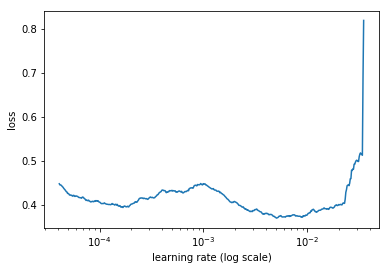

In [79]:
m.sched.plot(100)

In [88]:
m.fit(lr, 3, metrics=[RMSLE])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch:   0, train_loss: 0.258409, val_loss: 0.013121, RMSLE: 0.114549
epoch:   1, train_loss: 0.262441, val_loss: 0.022900, RMSLE: 0.151328
epoch:   2, train_loss: 0.259015, val_loss: 0.061330, RMSLE: 0.247648



In [81]:
m.fit(lr, 3, metrics=[RMSLE],cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch:   0, train_loss: 0.302729, val_loss: 0.011205, RMSLE: 0.105854
epoch:   1, train_loss: 0.303925, val_loss: 0.025228, RMSLE: 0.158832
epoch:   2, train_loss: 0.302663, val_loss: 0.051485, RMSLE: 0.226903



In [90]:
m.fit(lr, 5, metrics=[RMSLE], cycle_len=1,cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

 85%|████████▍ | 830/979 [00:07<00:01, 111.51it/s, loss=0.241]

Exception in thread Thread-119:
Traceback (most recent call last):
  File "/home/imtiaz/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/imtiaz/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/imtiaz/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch:   0, train_loss: 0.231902, val_loss: 0.032238, RMSLE: 0.179550
epoch:   1, train_loss: 0.244473, val_loss: 0.024185, RMSLE: 0.155515
epoch:   2, train_loss: 0.227937, val_loss: 0.012070, RMSLE: 0.109862
epoch:   3, train_loss: 0.240584, val_loss: 0.027983, RMSLE: 0.167282
epoch:   4, train_loss: 0.239576, val_loss: 0.017372, RMSLE: 0.131804
epoch:   5, train_loss: 0.214013, val_loss: 0.009813, RMSLE: 0.099060
epoch:   6, train_loss: 0.213050, val_loss: 0.012871, RMSLE: 0.113451
epoch:   7, train_loss: 0.249189, val_loss: 0.065129, RMSLE: 0.255204
epoch:   8, train_loss: 0.246434, val_loss: 0.037817, RMSLE: 0.194467
epoch:   9, train_loss: 0.236969, val_loss: 0.021397, RMSLE: 0.146276
epoch:  10, train_loss: 0.229280, val_loss: 0.011709, RMSLE: 0.108207
epoch:  11, train_loss: 0.225062, val_loss: 0.000201, RMSLE: 0.014190
epoch:  12, train_loss: 0.215211, val_loss: 0.003040, RMSLE: 0.055139
epoch:  13, train_loss: 0.211212, val_loss: 0.002170, RMSLE: 0.046582
epoch:  14, train_lo

In [91]:
pred_test=m.predict(True)
pred_test = np.exp(pred_test)

In [95]:
df_test['visitors']=np.round(pred_test)

In [96]:
df_test['id']=test['id']

In [97]:
csv_fn=f'{PATH}tmp/subRecruitVisitors.csv'
df_test[['id','visitors']].to_csv(csv_fn, index=False)
FileLink(csv_fn)

/home/imtiaz/Desktop/fastai/courses/dl1/data/Recruit/tmp/subRecruitVisitors.csv